## OCOM5203M Practical Assignment 2 - Image Caption Generation [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image to text model.
> 3. Use and compare two different text similarity metrics for evaluating an image to text model, and understand evaluation challenges.


### Setup and resources 

Having a GPU will speed up the image feature extraction process. If you would like to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using Python and PyTorch, and refer to the notebooks and exercises provided.

This coursework will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images, of 80 object categories, and at least five textual reference captions per image. Our subset consists of 5029 of these images, each of which has five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5029.

To download the data:

> 1. **Images**: download the zip file "coco_subset_images.zip (812MB)" [here](https://leeds365-my.sharepoint.com/:f:/g/personal/scsrss_leeds_ac_uk/EnVzgHGd-fhIhTcnxdK5hawBpGQz9isq8Bo8-Xhlwf6uwQ?e=e3LEru).
> 2. **Reference captions**: on the COCO [download page](https://cocodataset.org/#download), download the file named "2017 Train/Val annotations (241MB)". 
> 3. **Image meta data**: as our set is a subset of full COCO dataset, we have created a CSV file containing relevant meta data for our particular subset of images. You can download it also from Drive, "coco_subset_meta.csv" at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name or the automatic grading will be affected.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.


Final note:

> **Please include in this notebook everything that you would like to be marked, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):

mm21ab

Your full name:

Aindrila Basu

## Imports

Feel free to add to this section as needed.

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
import pandas as pd
import json

from torch.autograd import Variable
from PIL import Image
from natsort import natsorted
from torch import optim
import torchvision

Detect which device (CPU/GPU) to use.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet-152](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by a batch normalisation layer to speed up training. Those resulting features, as well as the reference text captions, are passed into a recurrent network (we will use an RNN). 

The reference captions used to compute loss are represented as numerical vectors via an embedding layer whose weights are learned during training.

![Encoder Decoder](encoder_decoder_diagramv2022.png)

The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the training more efficient by decoupling the networks. 

We will first extract the feature representations of the images from the Encoder and save them (Part 1). During training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity



## 1 Extracting image features [11 marks]

### 1.1 EncoderCNN

Read through the template EncoderCNN class below and complete the class.

In [3]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)

        # TO COMPLETE
        # keep all layers of the pretrained net except the last one
        self.model_11 = nn.Sequential(*list(resnet.children())[:-1])
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        
        # TO COMPLETE
        # remember no gradients are needed
        self.model_11.eval()
        with torch.no_grad():
            features = self.model_11(images)
        features = features.view(features.size(0), -1)
        return features


In [4]:
# instantiate encoder and put into evaluation mode.
encoder = EncoderCNN().to(device)
encoder.eval()

EncoderCNN(
  (model_11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

### 1.2 Processing the images

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [5]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [6]:
class CoCoData(Dataset):
    def __init__(self, main_dir, transform):
         
        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
         
        # List all images in folder and count them
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsorted(all_imgs)
        
    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self,index):
        img_loc = os.path.join(self.main_dir, self.total_imgs[index])
        # Use PIL for image loading
        image = Image.open(img_loc).convert("RGB")
        # Apply the transformations
        tensor_image = self.transform(image)
        return tensor_image

In [7]:
directory = "./images"
image_names = []

for entry in os.scandir(directory):
    if(entry.is_file()):
        image_names.append(entry.name)

dataset = CoCoData(main_dir=directory, transform=data_transform)

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


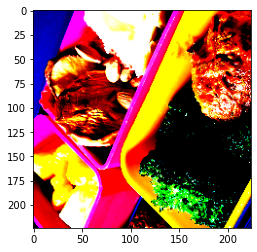

In [8]:
def timshow(x):
    xa = np.transpose(x)
    plt.imshow(xa)
    plt.show()

image = next(iter(train_loader))

timshow(torchvision.utils.make_grid(image))

In [ ]:
feature_list = []
for data in train_loader:
    inputs = data
    outputs = encoder(inputs)
    feature_list.append(outputs)
features = {}
for i in range(len(image_names)):
    features[image_names[i]] = feature_list[i]

In [ ]:
torch.save(features, 'features.pt')

## 2 Text preparation [23 marks]


### 2.1 Build the caption dataset

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="df_caption_set.png" alt="images matched to caption" width="700"/>

In [9]:
with open('./annotations/captions_train2017.json') as f:  
    data = json.load(f)
    
df_captions=pd.DataFrame(data['annotations'])
df_captions=df_captions.sort_values(by=['image_id'])
df_captions.head()

,image_id,id,caption
433247,9,661611,Closeup of bins of food that include broccoli ...
433499,9,667602,A bunch of trays that have different food.
433454,9,666765,"Colorful dishes holding meat, vegetables, frui..."
433325,9,663627,there are containers filled with different kin...
433263,9,661977,A meal is presented in brightly colored plasti...


In [10]:
df_coco = pd.read_csv('coco_subset_meta.csv', usecols = ['id', 'file_name'])
df_coco.rename(columns = {'id' : 'image_id'}, inplace = True)
df_coco=df_coco.sort_values(by=['image_id'])
df_coco.head()

,file_name,image_id
5002,000000000009.jpg,9
4503,000000000009.jpg,9
4902,000000000009.jpg,9
2308,000000000025.jpg,25
5814,000000000030.jpg,30


In [11]:
merged_df = pd.merge(df_captions, df_coco, on='image_id', how='inner')
merged_df = merged_df.sort_values(by='image_id')
merged_df = merged_df.drop_duplicates()
merged_df.head()

,image_id,id,caption,file_name
0,9,661611,Closeup of bins of food that include broccoli ...,000000000009.jpg
14,9,661977,A meal is presented in brightly colored plasti...,000000000009.jpg
11,9,663627,there are containers filled with different kin...,000000000009.jpg
8,9,666765,"Colorful dishes holding meat, vegetables, frui...",000000000009.jpg
5,9,667602,A bunch of trays that have different food.,000000000009.jpg


### 2.2 Clean the captions

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed. 

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.

In [12]:
merged_df['clean_caption']=merged_df['caption'].str.lower()
cap_list = []
for row in merged_df['clean_caption']:
    cap=""
    for ch in row:
        if(ch.isalpha() or ch == " "):
            cap+=ch
    cap_list.append(cap)
merged_df['clean_caption']=cap_list
merged_df=merged_df.sort_values(by=['image_id'])

In [13]:
captions_df = merged_df[['caption', 'clean_caption']]
captions_df.head(10)

,caption,clean_caption
0,Closeup of bins of food that include broccoli ...,closeup of bins of food that include broccoli ...
14,A meal is presented in brightly colored plasti...,a meal is presented in brightly colored plasti...
11,there are containers filled with different kin...,there are containers filled with different kin...
8,"Colorful dishes holding meat, vegetables, frui...",colorful dishes holding meat vegetables fruit ...
5,A bunch of trays that have different food.,a bunch of trays that have different food
18,A giraffe standing next to a forest filled wit...,a giraffe standing next to a forest filled wit...
17,Two giraffes standing in a tree filled area.,two giraffes standing in a tree filled area
19,A giraffe eating food from the top of the tree.,a giraffe eating food from the top of the tree
15,A giraffe standing up nearby a tree,a giraffe standing up nearby a tree
16,A giraffe mother with its baby in the forest.,a giraffe mother with its baby in the forest


### 2.3  Split the data

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [14]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [15]:
random.seed(0)

image_id_list=merged_df['image_id'].unique()
split_data = split_ids(image_id_list)

train_ids = split_data[0]
val_ids = split_data[1]
test_ids = split_data[2]

print(len(train_ids), len(val_ids), len(test_ids))

train_df = merged_df[merged_df['image_id'].isin(train_ids)]
val_df =  merged_df[merged_df['image_id'].isin(val_ids)]
test_df =  merged_df[merged_df['image_id'].isin(test_ids)]

3520 502 1007


In [16]:
l=[]
for i in train_ids:
    l.append(i)
for j in val_ids:
    l.append(j)

train_val = merged_df[merged_df['image_id'].isin(l)]

### 2.3 Building the vocabulary

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [17]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [18]:
captions=train_val['clean_caption'].tolist()
res = []
for c in captions:
    arr = c.split()
    for a in arr:
        res.append(a)
counts = dict(Counter(res))
duplicates = {key:value for key, value in counts.items() if value > 3}


In [19]:
print(len(duplicates))

2400


In [20]:
vocab = Vocabulary()
for k in duplicates:
    vocab.add_word(k)

### 2.4 The Dataset and DataLoader

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 4096).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [21]:
class COCO_Subset(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper
           
        """
        
        # TO COMPLETE
        self.df = df
        self.features = features
        self.vocab = vocab

    
    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """   
        
       # TO COMPLETE
        
        image_features = self.features[self.df['file_name'].iloc[index]]
        #print(image_features.shape)
        caption = self.df['clean_caption'].iloc[index]
        cap_words = caption.split()
        cap_tokens = []
        cap_pad = []
        for i in cap_words:
            cap_tokens.append(self.vocab(i))
        len_pad = 47 - len(cap_tokens) 
        #cap_pad = cap_tokens
        for i in cap_tokens:
            cap_pad.append(i)
        cap_pad.append(self.vocab('<end>'))
        for i in range(len_pad-1):
            cap_pad.append(self.vocab('<pad>'))
        ten_cap_pad = torch.tensor(cap_pad)
        #print(ten_cap_pad.shape)
        cap_tokens.append(self.vocab('<end>'))
        len_cap = len(cap_tokens)
        ten_cap = torch.tensor(len_cap)
        return (image_features.squeeze(), ten_cap_pad, ten_cap)
    
    
    def __len__(self):
        return len(self.df)
    

In [22]:
features = torch.load('features.pt')

dataset = COCO_Subset(train_df, features, vocab)

train_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

val_dataset = COCO_Subset(val_df, features, vocab)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

Load one batch of the training set and print out the shape of each returned Tensor.

In [23]:
train_iter = iter(train_loader)
feature, captions, lengths = train_iter.next()
print(feature.shape)
print(captions.shape)
print(lengths.shape)

torch.Size([64, 2048])
torch.Size([64, 47])
torch.Size([64])


## 3 Train DecoderRNN [15 marks]

### 3.1 Define the encoder model

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [24]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        self.resize = nn.Linear(2048, embed_size)
        
        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # TO COMPLETE
        self.rnn = nn.RNN(embed_size, hidden_size , num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)
        
        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)
    
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False) 
        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].
        
        hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens.data) # hiddens[0]
        return outputs
    
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids
    

In [25]:
# instantiate decoder
decoder = DecoderRNN(len(vocab)).to(device)

In [26]:
for param in decoder.parameters():
    print(param.shape)

torch.Size([256, 2048])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([2403, 256])
torch.Size([512, 256])
torch.Size([512, 512])
torch.Size([512])
torch.Size([512])
torch.Size([2403, 512])
torch.Size([2403])


### 3.2 Train the decoder

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [27]:
def stats(loader, decoder):
    running_loss = 0
    n = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            image_features, caption, length = data
            #image_features = image_features.squeeze(1)
            outputs = decoder(image_features, caption, length)      
            targets = pack_padded_sequence(caption, length, batch_first=True,enforce_sorted=False)[0]
            
            running_loss += loss_fn(outputs, targets)
            n += 1
            
    return running_loss/n

In [ ]:
nepochs = 50
results_path = './results/epochs50hidden512adam.pt'
statsrec = np.zeros((2,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.0001)

decoder.train()

for epoch in range(nepochs):
    running_loss = 0.0
    n = 0
    for i, data in enumerate(train_loader):
        image_features, caption, length = data
        #image_features = image_features.squeeze(1)
        targets = pack_padded_sequence(caption, length, batch_first=True,enforce_sorted=False)[0]
        
        optimizer.zero_grad()

        outputs = decoder(image_features, caption, length)
        
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n += 1

    ltrn = running_loss/n
    ltst = stats(val_loader, decoder)
    statsrec[:,epoch] = (ltrn, ltst)
    
# save network parameters and losses
torch.save({"state_dict": decoder.state_dict(), "stats": statsrec}, results_path)

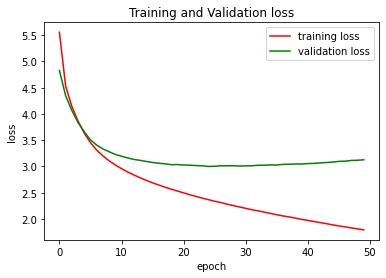

In [28]:
results_path = './results/epochs50hidden512adam.pt'
data = torch.load(results_path)
statsrec = data["stats"]

plt.plot(statsrec[0], 'r', label = 'training loss')
plt.plot(statsrec[1], 'g', label = 'validation loss' )
plt.legend(loc='upper right')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.show()

**As seen from the graph above, the model starts overfitting around the 15th epoch. So ideally, that should be our stopping point.**

In [29]:
decoder = DecoderRNN(len(vocab)).to(device)

nepochs = 15
results_path = './results/epochs15hidden512adam.pt'
statsrec = np.zeros((2,nepochs))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(decoder.parameters(), lr=0.0001)

decoder.train()

for epoch in range(nepochs):
    running_loss = 0.0
    n = 0
    for i, data in enumerate(train_loader):
        image_features, caption, length = data
        #image_features = image_features.squeeze(1)
        targets = pack_padded_sequence(caption, length, batch_first=True,enforce_sorted=False)[0]
        
        optimizer.zero_grad()

        outputs = decoder(image_features, caption, length)
        
        loss = loss_fn(outputs, targets)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        n += 1

    ltrn = running_loss/n
    ltst = stats(val_loader, decoder)
    statsrec[:,epoch] = (ltrn, ltst)
    print(f"epoch: {epoch+1} training loss: {ltrn: .3f} validation loss: {ltst: .3f} ")

# save network parameters, and losses
torch.save({"state_dict": decoder.state_dict(), "stats": statsrec}, results_path)

epoch: 1 training loss:  5.552 validation loss:  4.844 
epoch: 2 training loss:  4.560 validation loss:  4.368 
epoch: 3 training loss:  4.174 validation loss:  4.090 
epoch: 4 training loss:  3.896 validation loss:  3.863 
epoch: 5 training loss:  3.669 validation loss:  3.676 
epoch: 6 training loss:  3.482 validation loss:  3.525 
epoch: 7 training loss:  3.337 validation loss:  3.428 
epoch: 8 training loss:  3.223 validation loss:  3.354 
epoch: 9 training loss:  3.128 validation loss:  3.299 
epoch: 10 training loss:  3.052 validation loss:  3.244 
epoch: 11 training loss:  2.980 validation loss:  3.204 
epoch: 12 training loss:  2.914 validation loss:  3.173 
epoch: 13 training loss:  2.858 validation loss:  3.150 
epoch: 14 training loss:  2.807 validation loss:  3.122 
epoch: 15 training loss:  2.756 validation loss:  3.109 


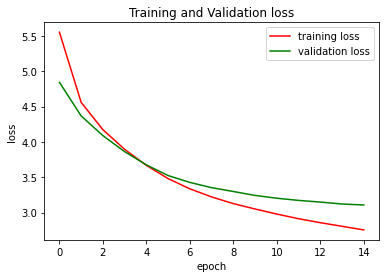

In [30]:
results_path = './results/epochs15hidden512adam.pt'
data = torch.load(results_path)
statsrec = data["stats"]

plt.plot(statsrec[0], 'r', label = 'training loss')
plt.plot(statsrec[1], 'g', label = 'validation loss' )
plt.legend(loc='upper right')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and Validation loss')
plt.show()

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [31]:
features = torch.load('features.pt')
test_filename_unique = test_df['file_name'].unique()
#random.Random(5).shuffle(test_filename_unique)
image_5 = test_filename_unique[0:5]
f=[]
for item in features:
    if(item in image_5):
        f.append(features[item])

ft=torch.cat(f)

In [32]:
decoder.eval()
gen_cap = []
with torch.no_grad():
    cap_dec = decoder.sample(ft)
for _, cap_data in enumerate(cap_dec):
    word_list = []
    for word in cap_data:
        word_list.append(vocab.idx2word[word.item()])
    end = word_list.index('<end>')
    word_list = word_list[0:end]
    gen_cap.append(word_list)
gen_cap = [" ".join(i) for i in gen_cap]
gen_cap

['a plate of food with a bowl of food',
 'a giraffe is standing in the grass',
 'a white plate with a clock on it',
 'a train is parked on a street',
 'a man is riding a motorcycle on a sidewalk']

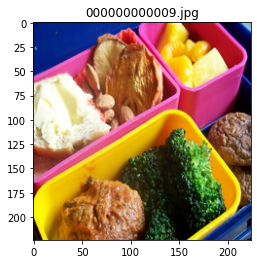

Reference Captions:
closeup of bins of food that include broccoli and bread
a meal is presented in brightly colored plastic trays
there are containers filled with different kinds of foods
colorful dishes holding meat vegetables fruit and bread
a bunch of trays that have different food


Generated Caption:
a plate of food with a bowl of food


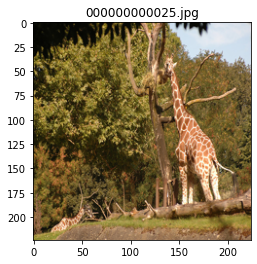

Reference Captions:
a giraffe standing next to a forest filled with trees
two giraffes standing in a tree filled area
a giraffe eating food from the top of the tree
a giraffe standing up nearby a tree 
a giraffe mother with its baby in the forest


Generated Caption:
a giraffe is standing in the grass


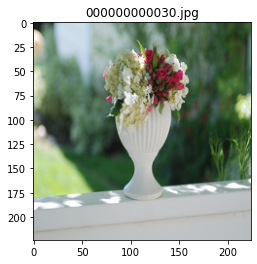

Reference Captions:
white vase with different colored flowers sitting inside of it 
a flower vase is sitting on a porch stand
a white vase filled with different colored flowers
a vase with red and white flowers outside on a sunny day
a white vase with many flowers on a stage


Generated Caption:
a white plate with a clock on it


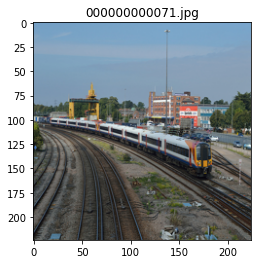

Reference Captions:
a train coming to a stop on the tracks out side
a passenger train glides around a curve on the outer track
the very long train is travelling down the tracks
a train engine carrying many carts down a track
a train coming down the tracks in the city


Generated Caption:
a train is parked on a street


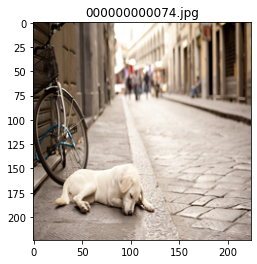

Reference Captions:
dog snoozing by a bike on the edge of a cobblestone street
the white dog lays next to the bicycle on the sidewalk
a white dog is sleeping on a street and a bicycle
a puppy rests on the street next to a bicycle
a picture of a dog laying on the ground


Generated Caption:
a man is riding a motorcycle on a sidewalk


In [33]:
for i in range(len(image_5)):
    #fig = plt.figure(figsize=(8,8))
    im = Image.open('./images/'+image_5[i])
    im = im.resize([224, 224])
    captions = list(merged_df['clean_caption'].loc[merged_df['file_name']== image_5[i]].values)
    #fig.add_subplot(i+1,2,1)
    plt.imshow(np.squeeze(im))
    plt.title(image_5[i])
    
    plt.show()
    print("Reference Captions:")
    for c in captions:
        print(c)
    print("\n")
    print ("Generated Caption:")
    print(gen_cap[i])

## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

###  5.1 BLEU score


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions. 

Display a histogram of the distribution of scores over the test set.

In [34]:
# TO COMPLETE

features = torch.load('features.pt')
test_filename_unique = test_df['file_name'].unique()
f=[]
for item in features:
    if(item in test_filename_unique):
        f.append(features[item])
ft=torch.cat(f)
captions = []
for img in test_filename_unique:
    captions.append(list(test_df['clean_caption'].loc[test_df['file_name']== img].values))
    
b=[]
for i in captions:
    a=[]
    for j in i:
        a.append(j.split())
    b.append(a)

decoder.eval()
gen_cap = []
with torch.no_grad():
    cap_dec = decoder.sample(ft)
for _, cap_data in enumerate(cap_dec):
    word_list = []
    for word in cap_data:
        word_list.append(vocab.idx2word[word.item()])
    end = word_list.index('<end>')
    word_list = word_list[0:end]
    gen_cap.append(word_list)
pred_cap = [" ".join(i) for i in gen_cap]

In [35]:
pred_df = pd.DataFrame(list(zip(test_filename_unique,pred_cap)), columns=['file_name','predicted_captions'])
full_pred_df = pd.merge(test_df, pred_df, on='file_name', how='inner')

In [36]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

scores =[]
for i in range(len(test_filename_unique)):
    reference = b[i]
    candidate = gen_cap[i]
    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)
    scores.append(score)
score_df = pd.DataFrame(list(zip(test_filename_unique,scores)), columns=['file_name','bleu_score'])

full_bleu_df = pd.merge(full_pred_df, score_df, on='file_name', how='inner')
score_df.head()

,file_name,bleu_score
0,000000000009.jpg,0.555556
1,000000000025.jpg,0.714286
2,000000000030.jpg,0.750000
3,000000000071.jpg,0.536769
4,000000000074.jpg,0.666667


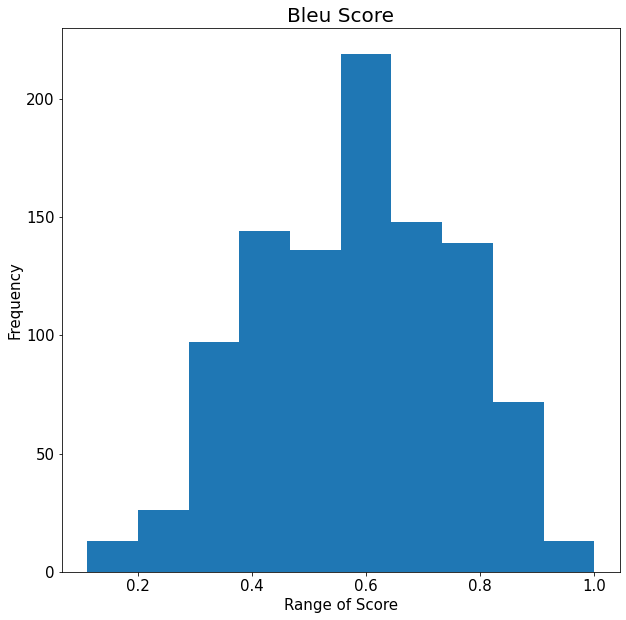

In [37]:
plt.title("Bleu Score", fontsize = 20)
plt.xlabel("Range of Score",fontsize=15)
plt.ylabel("Frequency",fontsize=15)
ax = score_df['bleu_score'].plot.hist(rot=0,figsize=(10,10),fontsize=15)
plt.show()

### 5.2 BLEU score examples

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

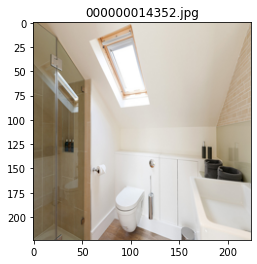

Reference Captions:
a new bathroom installed in an attic space
a toilet sink and shower in a bathroom with a skylight 
a bathroom is decorated in white and tan
a minimalistic bathroom with a sloping ceiling and skylight
a modern bathroom design with a skylight above the toilet


Generated Caption:
a bathroom with a toilet and a sink


Bleu Score:  1.0


In [38]:
# TO COMPLETE
highest_score = score_df['bleu_score'].max()
pred_cap_highest_score = pred_cap[score_df['bleu_score'].idxmax()]
ref_cap_highest_score = captions[score_df['bleu_score'].idxmax()]

im = Image.open('./images/'+score_df['file_name'][score_df['bleu_score'].idxmax()])
im = im.resize([224, 224])
    
plt.imshow(np.squeeze(im))
plt.title(score_df['file_name'][score_df['bleu_score'].idxmax()])
    
plt.show()
 
print("Reference Captions:")
for c in ref_cap_highest_score:
    print(c)
print("\n")
print ("Generated Caption:")
print(pred_cap_highest_score)
print("\n")
print("Bleu Score: ", highest_score)

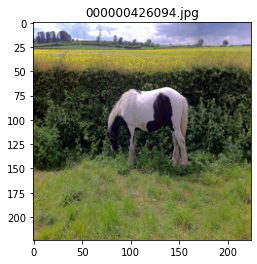

Reference Captions:
the white horse with black patches is eating grass near a bush
a black and white horse is eating some grass 
a horse that is kneeling down in the grass
a white and black horse some yellow flowers and grass and plants
there s a small black and white horse standing by bushes


Generated Caption:
a herd of sheep grazing on a field


Bleu Score:  0.11031211282307446


In [39]:
lowest_score = score_df['bleu_score'].min()
pred_cap_lowest_score = pred_cap[score_df['bleu_score'].idxmin()]
ref_cap_lowest_score = captions[score_df['bleu_score'].idxmin()]

im = Image.open('./images/'+score_df['file_name'][score_df['bleu_score'].idxmin()])
im = im.resize([224, 224])
    
plt.imshow(np.squeeze(im))
plt.title(score_df['file_name'][score_df['bleu_score'].idxmin()])
    
plt.show()
 
print("Reference Captions:")
for c in ref_cap_lowest_score:
    print(c)
print("\n")
print ("Generated Caption:")
print(pred_cap_lowest_score)
print("\n")
print("Bleu Score: ", lowest_score)

## 6 Caption evaluation using cosine similarity [12 marks]

###  6.1 Cosine similarity

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [40]:
features = torch.load('features.pt')
test_dataset = COCO_Subset(test_df, features, vocab)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=len(test_dataset),
    shuffle=False,
    num_workers=0
)

test_features, test_captions, test_lengths = next(iter(test_loader))


decoder.eval()
gen_cap = []
with torch.no_grad():
    cap_dec = decoder.sample(test_features)
for _, cap_data in enumerate(cap_dec):
    word_list = []
    for word in cap_data:
        word_list.append(vocab.idx2word[word.item()])
    end = word_list.index('<end>')
    word_list = word_list[0:end]
    gen_cap.append(word_list)
predicted_cap = [" ".join(i) for i in gen_cap]

In [41]:
# TO COMPLETE
embed_reference = decoder.embed(test_captions)

embed_predicted = decoder.embed(cap_dec)

reference_mean_vector = []
for ref in embed_reference: 
    reference_mean_vector.append(ref.mean(1))
    
predicted_mean_vector= []
for pred in embed_predicted:
    predicted_mean_vector.append(pred.mean(1))
    
cosine_score=[]
cosine = nn.CosineSimilarity(dim=0, eps=1e-9)
for i in range(len(reference_mean_vector)):
    output = (cosine(reference_mean_vector[i], predicted_mean_vector[i]))
    cosine_score.append(output)

cos_list = []
for score in cosine_score:
    cos_list.append(score.detach().numpy())
    
cosine_df = pd.DataFrame(list(zip(test_df['file_name'], cos_list)), columns=['file_name','cosine_score'])
cosine_df.head()

torch.Size([5036, 47, 256])


,file_name,cosine_score
0,000000000009.jpg,0.9428736
1,000000000009.jpg,0.9730478
2,000000000009.jpg,0.9545137
3,000000000009.jpg,0.97597456
4,000000000009.jpg,0.9841186


In [42]:
#average of cos similarity
print("The average score of cosine similarity:",cosine_df['cosine_score'].mean())

The average score of cosine similarity: 0.8931099404599384


In [43]:
cosine_df['cosine_score']=cosine_df['cosine_score'].astype(float, errors='raise')

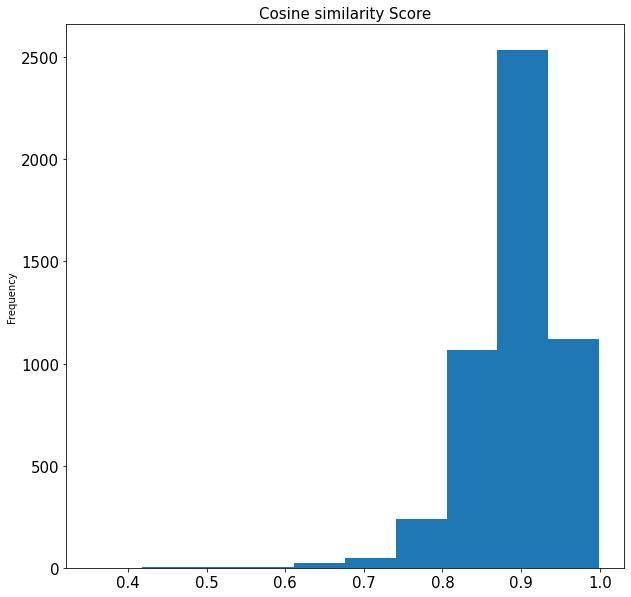

In [44]:
# Creating histogram 
plt.title("Cosine similarity Score", fontsize=15)
ax1= cosine_df['cosine_score'].plot.hist(rot=0,figsize=(10,10),fontsize=15)

#### 6.2 Cosine similarity examples 

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

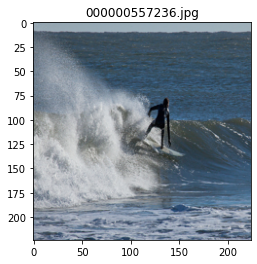

Reference Captions:
a surfer gets caught in the tidal wave
a person riding a wave on a surfboard
person on surfboard riding a wave on the ocean
a person riding a surf board on a wave
a surfer catches a wave in the ocean


Generated Caption:
a man riding a wave on a surfboard


Cosine Similarity:  0.9988404512405396


In [45]:
# TO COMPLETE
highest_score = cosine_df['cosine_score'].max()
idxmax = cosine_df['cosine_score'].idxmax()
pred_cap_highest_score = predicted_cap[idxmax]
pred_cap_highest_score = pred_cap_highest_score.replace(' <end>', '')

file_name = cosine_df['file_name'][idxmax]

ref_cap_highest_score = list(test_df[test_df['file_name']==file_name]['clean_caption'])

im = Image.open('./images/'+file_name)
im = im.resize([224, 224])
    
plt.imshow(np.squeeze(im))
plt.title(file_name)
    
plt.show()
 
print("Reference Captions:")
for c in ref_cap_highest_score:
    print(c)
print("\n")
print ("Generated Caption:")
print(pred_cap_highest_score)
print("\n")
print("Cosine Similarity: ", highest_score)

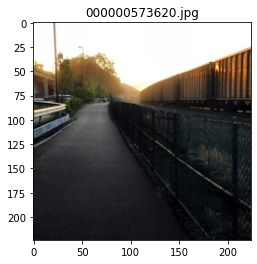

Reference Captions:
a paved area with a fence beside train tracks
a train traveling down tracks next to a metal fence
a train that is sitting on the tracks near a fence
a fence and  a path with a rail guard run alongside a railroad track with a receding row of railroad cars that fade off into a distance that holds sun glare vegetation a building and cars   
several train cars are running along a sidewalk


Generated Caption:
a train is parked in a parking lot


Cosine Similarity:  0.3538179099559784


In [46]:
lowest_score = cosine_df['cosine_score'].min()
idxmin = cosine_df['cosine_score'].idxmin()
pred_cap_lowest_score = predicted_cap[idxmin]
pred_cap_lowest_score = pred_cap_lowest_score.replace(' <end>', '')

file_name = cosine_df['file_name'][idxmin]

ref_cap_lowest_score = list(test_df[test_df['file_name']==file_name]['clean_caption'])

im = Image.open('./images/'+file_name)
im = im.resize([224, 224])
    
plt.imshow(np.squeeze(im))
plt.title(file_name)
    
plt.show()
 
print("Reference Captions:")
for c in ref_cap_lowest_score:
    print(c)
print("\n")
print ("Generated Caption:")
print(pred_cap_lowest_score)
print("\n")
print("Cosine Similarity: ", lowest_score)


## 7 Comparing BLEU and Cosine similarity [16 marks]

### 7.1 Test set distribution of scores

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below). 

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

Average Bleu Score: 0.5823885450920799
Average Cosine Similarity Score:  0.9465550117230159


Text(0, 0.5, 'Frequency')

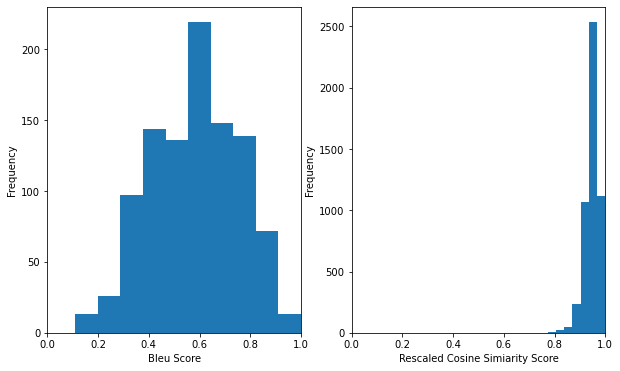

In [47]:
# TO COMPLETE
cos_list_rescaled = []
for cos in cos_list:
    cos_list_rescaled.append(cos/2+0.5)
rescaled_cosine_df = pd.DataFrame(list(zip(test_df['file_name'], cos_list_rescaled)), 
                                  columns=['file_name','rescaled_cosine_score'])

print("Average Bleu Score:", score_df['bleu_score'].mean())
print("Average Cosine Similarity Score: ", rescaled_cosine_df['rescaled_cosine_score'].mean())


fig = plt.figure(figsize=[10,10])
sub1 = plt.subplot(1,2,1)
score_df['bleu_score'].plot.hist(figsize=(10,6))
sub1.set_xbound(0,1)
plt.xlabel("Bleu Score")
plt.ylabel("Frequency")

sub2=plt.subplot(1,2,2)
rescaled_cosine_df['rescaled_cosine_score'].plot.hist(figsize=(10,6))
sub2.set_xbound(0,1)
plt.xlabel("Rescaled Cosine Simiarity Score")
plt.ylabel("Frequency")

**Bleu Score**

Weaknesses of Bleu score:
- It does not recognise the meaning of words and checks only for words that are exactly the same. When a different version of the same word is used, Bleu score considers it as incorrect.
- It also dismisses the significance of words and the order in which they appear.

Strengths of Bleu score:
- It is quite simple to compute and comprehend and is similar to how humans analyse text. It is also independent of the language used.
- Bleu score can be used for comparing more than one reference to one prediction.


**Cosine Similarity Score**

Weaknesses of Cosine Similarity score:
- One major drawback of Cosine similarity is that the magnitude of vectors is overlooked in favour of their direction.
- Moreover, it lets us compare only a pair of sentences at a time.

Strengths of Cosine Similarity score:
- The Cosine similarity performs well when comparing sentences having synonyms in them because even if the vectors are far off by Euclidian distance, the angle between them might still be small. 
- Another benefit of Cosine similarity is its speed, as well as the fact that it is particularly good for sparse data.


 ### 7.2 Analysis of individual examples
 
Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

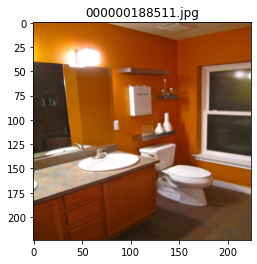

Reference Captions:
a bathroom has orange walls a window a white toilet and a counter with a sink in it
a bathroom with a white toilet next to a large window
a bathroom with orange walls marble sink counter and linoleum floors
an orange and white bathroom with two sinks
bathroom with orange walls and a window with no treatment


Generated Caption:
a bathroom with a toilet and a mirror


Bleu Score:  0.875
Cosine Similarity:  0.8758843839168549


In [48]:
# TO COMPLETE
diff_df=pd.DataFrame(full_bleu_df['bleu_score'].subtract(rescaled_cosine_df['rescaled_cosine_score']).abs(), columns=['score_diff'])

similar_idx = diff_df['score_diff'].idxmin()
similar_cosine_score = rescaled_cosine_df['rescaled_cosine_score'][similar_idx]
similar_bleu_score = full_bleu_df['bleu_score'][similar_idx]

similar_pred_cap = full_bleu_df['predicted_captions'][similar_idx]
file_name = full_bleu_df['file_name'][similar_idx]

similar_ref_cap = list(test_df[test_df['file_name']==file_name]['clean_caption'])

im = Image.open('./images/'+file_name)
im = im.resize([224, 224])
    
plt.imshow(np.squeeze(im))
plt.title(file_name)
    
plt.show()
 
print("Reference Captions:")
for c in similar_ref_cap:
    print(c)
print("\n")
print ("Generated Caption:")
print(similar_pred_cap)
print("\n")
print("Bleu Score: ", similar_bleu_score)
print("Cosine Similarity: ", similar_cosine_score)


**Explanation**

The scores are similar for both Bleu and Cosine similarity as the predicted caption has words in the same order as the reference captions and the frequency of occurrence of each word is also the same as the reference.



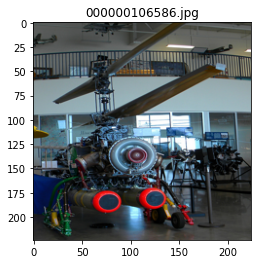

Reference Captions:
a engine sits parked inside of a ware house
the machine is being displayed in a very famous museum
an engine with a propeller blade attached in a large open building
a wreckage of a dismantled plane in the workshop
an early example of a helicopter at a museum


Generated Caption:
a <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


Bleu Score:  0.11111111111111109
Cosine Similarity:  0.9873544871807098


In [49]:
different_idx = diff_df['score_diff'].idxmax()
different_cosine_score = rescaled_cosine_df['rescaled_cosine_score'][different_idx]
different_bleu_score = full_bleu_df['bleu_score'][different_idx]

different_pred_cap = full_bleu_df['predicted_captions'][different_idx]
file_name = full_bleu_df['file_name'][different_idx]

different_ref_cap = list(test_df[test_df['file_name']==file_name]['clean_caption'])

im = Image.open('./images/'+file_name)
im = im.resize([224, 224])
    
plt.imshow(np.squeeze(im))
plt.title(file_name)
    
plt.show()
 
print("Reference Captions:")
for c in different_ref_cap:
    print(c)
print("\n")
print ("Generated Caption:")
print(different_pred_cap)
print("\n")
print("Bleu Score: ", different_bleu_score)
print("Cosine Similarity: ", different_cosine_score)

**Explanation** 

There is a huge difference in Bleu score and Cosine similarity in this case.
The words and their order in the predicted caption is not the same as the reference captions. Hence, the Bleu score is quite low.
But, the frequency of occurrence of the words is quite similar to the refernce which is why we have a higher Cosine similarity score.

### Overall quality [5 marks]

See the top of the notebook for submission instructions.